In [1]:
%pip install jupyter==1.0.0 jupyterlab==3.0.0 matplotlib==3.3.3 numpy==1.19.4 torch==1.7.1 gym
%config Completer.use_jedi = False  #使能自动补全，jupyter notebook新版采用jedi自动补全，但是经常无效

Looking in indexes: https://pypi.douban.com/simple/


You should consider upgrading via the '/home/dell/myProjects/dqn/dqn_pytorch_cartpole/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import cartpole_swingup_envs
from torchviz import make_dot, make_dot_from_trace

In [3]:
# 超参数
# 论文中的参数对应的是处理图片和卷积网络的参数，对于Gym CartPole环境来说，输入到模型的是数字数据，不适宜使用卷积网络，所以参数值会相应的改变
BATCH_SIZE = 32            
LR = 0.01                  
EPSILON = 0.9               
GAMMA = 0.9                
TARGET_REPLACE_ITER = 100  
MEMORY_CAPACITY = 2000     
EPISODE=2000                

#env = gym.make('CartPoleSwingUpDiscrete-v0')
env = gym.make('CartPole-v0')
env = env.unwrapped
#env = gym.wrappers.Monitor(env, './video/',video_callable=lambda episode_id: True,force = True)

N_ACTIONS = env.action_space.n
N_STATES = env.observation_space.shape[0]

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device=torch.device("cpu")
torch.FloatTensor=torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor #如果有GPU和cuda，数据将转移到GPU执行
torch.LongTensor=torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor


In [4]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        self.fc1.weight.data.normal_(0, 0.1)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        self.out.weight.data.normal_(0, 0.1)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [5]:
class DQN:
    def __init__(self):
        self.net,self.target_net=Net().to(device),Net().to(device)
        
        self.learn_step_counter=0
        self.memory_counter=0
        self.memory = np.zeros((MEMORY_CAPACITY, N_STATES * 2 + 2))     # initialize memory
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=LR)
        self.loss_func = nn.MSELoss()
        

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:  
            actions_value = self.net.forward(x)
            action = torch.max(actions_value, 1)[1].data.cpu().numpy()
            action = action[0]
        else:   
            action = np.random.randint(0, N_ACTIONS)
            
        return action
        
    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, [a, r], s_))
        # replace the old memory with new memory
        index = self.memory_counter % MEMORY_CAPACITY
        self.memory[index, :] = transition
        self.memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_s = torch.FloatTensor(batch_memory[:, :N_STATES])
        batch_a = torch.LongTensor(batch_memory[:, N_STATES:N_STATES+1].astype(int))
        batch_r = torch.FloatTensor(batch_memory[:, N_STATES+1:N_STATES+2])
        batch_s_ = torch.FloatTensor(batch_memory[:, -N_STATES:])

        
        q = self.net(batch_s).gather(1, batch_a)  # shape (batch, 1)
        q_target = self.target_net(batch_s_).detach()     # detach from graph, don't backpropagate
        y = batch_r + GAMMA * q_target.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss = self.loss_func(q, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
       

Episode:  44 | Episode_reward:  54.08
Episode:  45 | Episode_reward:  2.9
Episode:  46 | Episode_reward:  2.73
Episode:  47 | Episode_reward:  1.55
Episode:  48 | Episode_reward:  1.52
Episode:  49 | Episode_reward:  1.44
Episode:  50 | Episode_reward:  3.28
Episode:  51 | Episode_reward:  15.2
Episode:  52 | Episode_reward:  3.28
Episode:  53 | Episode_reward:  16.55
Episode:  54 | Episode_reward:  9.44
Episode:  55 | Episode_reward:  5.43
Episode:  56 | Episode_reward:  3.91
Episode:  57 | Episode_reward:  2.79
Episode:  58 | Episode_reward:  1.0
Episode:  59 | Episode_reward:  32.18
Episode:  60 | Episode_reward:  58.07
Episode:  61 | Episode_reward:  71.23
Episode:  62 | Episode_reward:  213.41
Episode:  63 | Episode_reward:  138.44
Episode:  64 | Episode_reward:  201.69
Episode:  65 | Episode_reward:  112.89
Episode:  66 | Episode_reward:  281.09
Episode:  67 | Episode_reward:  97.97
Episode:  68 | Episode_reward:  454.29
Episode:  69 | Episode_reward:  105.73
Episode:  70 | Episo

Episode:  253 | Episode_reward:  288.04
Episode:  254 | Episode_reward:  922.71
Episode:  255 | Episode_reward:  269.56
Episode:  256 | Episode_reward:  419.24
Episode:  257 | Episode_reward:  1153.76
Episode:  258 | Episode_reward:  121.91
Episode:  259 | Episode_reward:  909.35


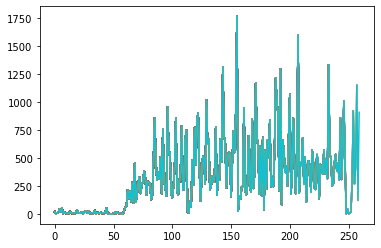

In [6]:
dqn = DQN()
   
plot_x_data,plot_y_data=[],[]
for i_episode in range(260):
    s = env.reset()
   # frames = []
    episode_reward = 0
    while True:
        #env.render()
        a = dqn.choose_action(s)

        # take action
        s_, r, done, info = env.step(a)

        # modify the reward
        x, x_dot, theta, theta_dot = s_
        r1 = (env.x_threshold - abs(x)) / env.x_threshold - 0.8
        r2 = (env.theta_threshold_radians - abs(theta)) / env.theta_threshold_radians - 0.5
        r = r1 + r2

        dqn.store_transition(s, a, r, s_)

        episode_reward += r
        if dqn.memory_counter > MEMORY_CAPACITY:
            dqn.learn()
            if done:
                print('Episode: ', i_episode,
                      '| Episode_reward: ', round(episode_reward, 2))

        if done:
            break
        s = s_
    plot_x_data.append(i_episode)
    plot_y_data.append(episode_reward)
    plt.plot(plot_x_data,plot_y_data)
    